In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import keras
import math

from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from scipy import optimize
from methods import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
#import the data
train, test, y_test = prepare_data("FD004.txt")
#remove the irrelevant features (null features after)
train = train.drop(['T20','P20','Nf_dmd','PCNfR_dmd','farB'],axis=1)
test = test.drop(['T20','P20','Nf_dmd','PCNfR_dmd','farB'],axis=1)
train.shape, test.shape, y_test.shape

((61249, 22), (41214, 21), (248, 1))

In [4]:
chosen_sensors = ['T24', 'T30', 'T50', 'P15', 'P30','Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31','W32']

# add operational conditions
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(test)

#scale the data
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, chosen_sensors)

In [5]:
#after scaling the data we can then proceed to drop these variables as they no longer serve a purpose
data_train = X_train_condition_scaled.drop(['Altitude', 'Mach', 'TRA','op_cond'],axis=1)
data_test = X_test_condition_scaled.drop(['Altitude', 'Mach', 'TRA','op_cond'],axis=1)

In [6]:
# smooth the signal 
train_smooth = exponential_smoothing(data_train,chosen_sensors,0,0.3)
test_smooth = exponential_smoothing(data_test,chosen_sensors,0,0.3)

In [6]:
def rul_piecewise_fct(X_train, rul):
    
    X_train['RUL'].clip(upper=rul, inplace=True)
    
    return X_train

In [7]:
df_train_unit = train_smooth.Unit
df_test_unit = test_smooth.Unit
df_train_RUL = train_smooth.RUL
train_smooth['RUL'].clip(upper=130, inplace=True)
Xtrain = train_smooth.drop(['RUL','Unit'],axis=1)
Xtest = test_smooth.drop(['Unit'],axis=1)

In [7]:
def create_model_lstm(input_shape, nodes_per_layer, dropout, learning_rate_):
    model = Sequential()
    model.add(LSTM(units=nodes_per_layer, activation='tanh',input_shape=(sequence_length, len(remaining_sensors_7))))
    model.add(Dense(units=nodes_per_layer, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))
    model.compile(loss=['mse'],metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=learning_rate_))
    return model

In [8]:
def prep_data(train, test, chosen_sensors, alpha):
    X_train_interim = add_operating_condition(train)
    X_test_interim = add_operating_condition(test)

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors_7)

    X_train_interim = exponential_smoothing(X_train_interim, chosen_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, chosen_sensors, 0, alpha)
    
    return X_train_interim, X_test_interim

In [9]:
#get output file from RStudio after performining ClustOfVar

df7 = pd.read_csv('C:/Users/aalah/Downloads/d7.txt',sep=',',names=['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6','cluster7'
])
df_train_rul = train['RUL']
df_train_unit = train['Unit']
df_test_unit = test['Unit']

#As the file has train and test merged together, we will split them into train and test

cluster7_train = df7[ :61249 ].reset_index()
cluster7_train = cluster7_train.drop('index',axis=1)
cluster7_test = df7[ 61249 : ].reset_index()
cluster7_test = cluster7_test.drop('index',axis=1)


#We add Unit and RUL to these newly created datasets

mid7_train = pd.concat([cluster7_train, df_train_rul], axis=1, join="inner")
train_7 = pd.concat([df_train_unit,mid7_train], axis=1, join="inner")
test_7 = pd.concat([df_test_unit,cluster7_test], axis=1, join="inner")


In [10]:
#sequence_length = 30 #TW was found using grid-search


#train_7['RUL'].clip(upper=130, inplace=True) #Rectified RUL was found using grid-search

remaining_sensors_7 = ['cluster1','cluster2','cluster3','cluster4','cluster5','cluster6','cluster7']


In [11]:
alpha_list = [0.2,0.3,0.5,0.7,0.9]
epoch_list = list(np.arange(5,50+1,5))
nodes_list = list(np.arange(32,512+1,32))

dropouts_list = list(np.arange(1,5)/10)  
# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
#TW_list = list(np.arange(10,30+1,5))
TW_list = [10,20,30,40,50]
piece_wise_rul_list = [100,120,130,140,150]
batch_size_list = list(np.arange(32,512+1,32))
learnin_rates_list = [0.00001, 0.0001, 0.001, 0.02,0.002,0.0002,0.03,0.003, 0.0003,0.01,0.00002]

 
tuning_options = np.prod([len(alpha_list),
                          
                          len(nodes_list),
                          len(dropouts_list),
                          len(learnin_rates_list),
                          len(batch_size_list)])
tuning_options

5120

In [70]:
ITERATIONS = 5

results_TW_10_iter = pd.DataFrame()

for i in range(ITERATIONS):
    
    print('iteration ', i+1)
    
    score_val = []
    mse_val = []
    R2_val = []
    RMSE = []
    
    # init parameters
    #alpha = random.sample(alpha_list, 1)[0]
    epochs = 20
    sequence_length = 30
    nodes_per_layer = 128
    dropout = 0.2
    learn_rate =  0.01
    batch_size = 384
    #rul_piecewise= random.sample(piece_wise_rul_list, 1)[0]
    rul_piecewise= piece_wise_rul_list[i % len(piece_wise_rul_list)]
    # smooth the signal 
    #train_smooth = exponential_smoothing(data_train,chosen_sensors,0,alpha)
    #test_smooth = exponential_smoothing(data_test,chosen_sensors,0,alpha)
    # create model
    X_train_interim = rul_piecewise_fct(train_7,rul_piecewise)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    input_shape = (sequence_length, len(remaining_sensors_7))
    model = create_model_lstm(input_shape, nodes_per_layer, dropout,learn_rate)
    #X_train_interim, X_test_interim = prep_data(train, test, chosen_sensors, alpha)
    # create train-val split
    #gss = GroupShuffleSplit(n_splits=5, train_size=0.80, random_state=42)
    gkf_cv = GroupKFold(n_splits=5)
    with tf.device('/device:GPU:0'):
        for train_unit, val_unit in gkf_cv.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
            train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
            train_split_array = gen_data_sequences_train(X_train_interim, sequence_length, remaining_sensors_7, train_unit)
            train_split_label = gen_rul_sequences_train(X_train_interim, sequence_length, ['RUL'], train_unit)
        
            val_unit = X_train_interim['Unit'].unique()[val_unit]
            val_split_array = gen_data_sequences_train(X_train_interim, sequence_length, remaining_sensors_7, val_unit)
            val_split_label = gen_rul_sequences_train(X_train_interim, sequence_length, ['RUL'], val_unit)

        
            history = model.fit(train_split_array, train_split_label,
                                validation_data=(val_split_array, val_split_label),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=0)

            test_gen = (list(gen_test_data(test_7[test_7['Unit']==unit_nr], sequence_length,remaining_sensors_7, -99.))
                        for unit_nr in test_7['Unit'].unique())
            test_array = np.concatenate(list(test_gen)).astype(np.float32)
            
            mse_val.append(history.history['val_loss'][-1])
            y_hat_val_split = model.predict(test_array)
            R2_val.append(r2_score(test_rul, y_hat_val_split))
            RMSE.append(np.sqrt(mean_squared_error(test_rul, y_hat_val_split)))
            score_val.append(compute_s_score(test_rul, y_hat_val_split)) 
            # append results
        d = {'RMSE_val':np.sqrt(mse_val),'RMSE_test':RMSE,'R2_test':np.mean(R2_val), 'Score_test':np.mean(score_val),
            #'alpha':alpha,
             'rul_piecewise':rul_piecewise, 'sequence_length':sequence_length }
        results_TW_10_iter = results_TW_10_iter.append(pd.DataFrame(d), ignore_index=True)

iteration  1


KeyboardInterrupt: 

In [56]:
results_TW_10_iter

,RMSE_val,RMSE_test,R2_test,Score_test,rul_piecewise,sequence_length
0,9.909810,11.154262,0.899681,528.682732,100,30
1,11.085535,10.869654,0.899681,528.682732,100,30
2,10.786652,11.277052,0.899681,528.682732,100,30
3,9.669874,11.165940,0.899681,528.682732,100,30
4,9.358158,10.538044,0.899681,528.682732,100,30
5,11.062903,12.435577,0.884895,1032.497000,120,30
6,11.979004,12.557872,0.884895,1032.497000,120,30
7,10.763518,11.440153,0.884895,1032.497000,120,30
8,10.363221,11.312118,0.884895,1032.497000,120,30
9,10.946024,11.114011,0.884895,1032.497000,120,30


In [57]:
# Group the results by hyperparameters
groups = results_TW_10_iter.groupby(['rul_piecewise'])

# Calculate the mean and standard deviation of the metrics for each group
means = groups.mean()
stds = groups.std()

# Print the results
print("Mean results by hyperparameters:")
print(means)
print("\nStandard deviation of results by hyperparameters:")
print(stds)


Mean results by hyperparameters:
                RMSE_val  RMSE_test   R2_test   Score_test  sequence_length
rul_piecewise                                                              
100            10.162006  11.000990  0.899681   528.682732             30.0
120            11.022934  11.771946  0.884895  1032.497000             30.0
130            10.315751  11.463092  0.890873   608.748609             30.0
140            10.288671  11.909599  0.882378   725.014097             30.0
150            10.671761  10.967225  0.900342   494.236237             30.0

Standard deviation of results by hyperparameters:
               RMSE_val  RMSE_test  R2_test  Score_test  sequence_length
rul_piecewise                                                           
100            0.740786   0.299366      0.0         0.0              0.0
120            0.596678   0.673144      0.0         0.0              0.0
130            1.376954   0.635560      0.0         0.0              0.0
140            1.03

In [68]:
groups_tw = results_TW_10_iter.groupby(['rul_piecewise'])
data_tw = pd.DataFrame(columns=['TW', 'mean', 'std'])
for group_name, group_data in groups_tw:
    grouped_data = group_data['RMSE_val']
    new_row = {'TW': group_name, 'mean': grouped_data.mean(), 'std': grouped_data.std()}
    data_tw = data_tw.append(new_row, ignore_index=True)

print(data_tw)

      TW       mean       std
0  100.0  10.162006  0.740786
1  120.0  11.022934  0.596678
2  130.0  10.315751  1.376954
3  140.0  10.288671  1.034195
4  150.0  10.671761  0.807728


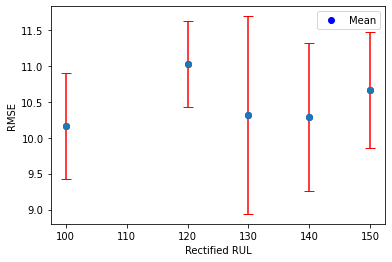

In [169]:
import matplotlib.pyplot as plt

# Plot the mean RMSE with error bars for each RUL group
plt.errorbar(data_tw['TW'], data_tw['mean'], yerr=data_tw['std'], fmt='o', ecolor='red', capsize=5)
plt.plot(data_tw['TW'], data_tw['mean'], 'bo', label='Mean')
# Set the x-axis label
plt.xlabel('Rectified RUL')

# Set the y-axis label
plt.ylabel('RMSE')

# Set the title of the plot
#plt.title('RMSE vs alpha')
plt.legend()
# Show the plot
plt.show()


In [14]:
results.to_csv('C:/Users/aalah/Downloads/results_FD004_clusters_all.csv',index=False)

In [46]:
groups_alpha = res.groupby('alpha')
data_alpha = pd.DataFrame(columns=['alpha', 'mean', 'std'])
for group_name, group_data in groups_alpha:
    grouped_data = group_data['RMSE_val']
    new_row = {'alpha': group_name, 'mean': grouped_data.mean(), 'std': grouped_data.std()}
    data_alpha = data_alpha.append(new_row, ignore_index=True)

print(data_alpha)

  alpha       mean       std
0   0.2  22.042262  2.235815
1   0.3  12.087272  1.288329
2   0.5  22.524987  2.099119
3   0.7  21.734649   2.09848
4   0.9  19.561987  2.889458


In [ ]:
#The chosen sensors signify the remaining 16 sensors after normalization
chosen_sensors = ['T24', 'T30', 'T50', 'P15', 'P30','Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31','W32']

#adding operational condition
X_train_interm = add_operational_condition(train)
X_test_interm = add_operational_condition(test)
#normalizing based on these operational condition
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_interm, X_test_interm, chosen_sensors)

#drop the operational condition variables as they were only helpful for the scaling
data_train = X_train_condition_scaled.drop(['Cycle','Altitude', 'Mach', 'TRA','op_cond'],axis=1)
data_test = X_test_condition_scaled.drop(['Cycle','Altitude', 'Mach', 'TRA','op_cond'],axis=1)

#perform exponential smoothing on the data
train_smooth = exponential_smoothing(data_train,chosen_sensors,0,0.3) #here alpha=0.3, was found when performing GridSearch
test_smooth = exponential_smoothing(data_test,chosen_sensors,0,0.3)

In [ ]:
train_smooth['RUL'].clip(upper=100, inplace=True)
sequence_length = 20

In [ ]:
# create sequences train, test 
train_array_7 = gen_data_sequences_train(train_7, sequence_length,remaining_sensors_7)
label_array_7 = gen_rul_sequences_train(train_7, sequence_length, ['RUL'])

test_gen_7 = (list(gen_test_data(test_7[test_7['Unit']==unit_nr], sequence_length,remaining_sensors_7, -99.))
           for unit_nr in test_7['Unit'].unique())
test_array_7 = np.concatenate(list(test_gen_7)).astype(np.float32)

y_true_clipped = y_test.copy()
y_true_clipped.clip(upper=100,inplace=True)

In [ ]:
## updated version 

ITERATIONS = 5

results_TW = pd.DataFrame()

# Define LSTM model
input_shape = (sequence_length, len(remaining_sensors_7))
model = create_model_lstm(input_shape, nodes_per_layer, dropout,learn_rate)

# Define test generator
test_gen = (list(gen_test_data(test_7[test_7['Unit']==unit_nr], sequence_length,remaining_sensors_7, -99.))
            for unit_nr in test_7['Unit'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

for i in range(ITERATIONS):
    
    print('iteration ', i+1)
    
    score_val = []
    mse_val = []
    R2_val = []
    RMSE = []
    
    # init parameters
    #alpha = random.sample(alpha_list, 1)[0]
    epochs = 20
    sequence_length = 30
    nodes_per_layer = 128
    dropout = 0.2
    learn_rate =  0.01
    batch_size = 384
    rul_piecewise= random.sample(piece_wise_rul_list, 1)[0]
    # smooth the signal 
    #train_smooth = exponential_smoothing(data_train,chosen_sensors,0,alpha)
    #test_smooth = exponential_smoothing(data_test,chosen_sensors,0,alpha)
    # create model
    X_train_interim = rul_piecewise_fct(train_7,rul_piecewise)
    test_rul = rul_piecewise_fct(y_test,rul_piecewise)
    
    # create train-val split
    #gss = GroupShuffleSplit(n_splits=5, train_size=0.80, random_state=42)
    gkf_cv = GroupKFold(n_splits=5)
    with tf.device('/device:GPU:0'):
        for fold_idx, (train_unit, val_unit) in enumerate(gkf_cv.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique())):
            train_unit = X_train_interim['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
            train_split_array = gen_data_sequences_train(X_train_interim, sequence_length, remaining_sensors_7


In [71]:
def create_model_lstm(input_shape,nodes_per_layer, dropout, learning_rate_):
    #create_model_lstm(input_shape, nodes_per_layer, dropout,learn_rate)

    model = Sequential()
    model.add(LSTM(units=nodes_per_layer, activation='tanh',input_shape=input_shape))
    model.add(Dense(units=nodes_per_layer, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=learning_rate_))
    return model

In [131]:
epochs = 10
batch_size = 32
def create_3lstm_model(input_shape,nodes_per_layer, dropout, learning_rate_):
    model = Sequential()
    model.add(LSTM(units=128,return_sequences=True, activation='tanh',input_shape=input_shape))
    model.add(Dense(units=128, activation='relu'))
    model.add(LSTM(units=128, activation='tanh',return_sequences=True))
    model.add(Dense(units=128, activation='relu'))
    model.add(LSTM(units=128, activation='tanh'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=learning_rate_))
    return model



In [ ]:
from sklearn.model_selection import GroupKFold

# assume X and y are your training data and labels
# assume groups is a list/array that specifies the group for each sample in X

# define the number of folds and create the cross-validation object
n_folds = 5
cv = GroupKFold(n_splits=n_folds)

# initialize a list to store RMSE scores for each fold
rmse_scores = []

# loop over the folds and perform cross-validation
for train_idx, test_idx in cv.split(X_train_interim['Unit'].unique(), groups=X_train_interim['Unit'].unique()):
    # extract the training and test data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # train the model on the training data
    model.fit(X_train, y_train)
    
    # evaluate the model on the test data and calculate RMSE
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # add the RMSE score to the list
    rmse_scores.append(rmse)

# calculate mean and standard deviation of RMSE scores
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print(f"Mean RMSE: {mean_rmse:.2f}, Std RMSE: {std_rmse:.2f}")


In [141]:
from sklearn.decomposition import PCA
train_smooth['RUL'].clip(upper=130, inplace=True)
Xtrain = train_smooth.drop(['RUL','Unit'],axis=1)
Xtest = test_smooth.drop(['Unit'],axis=1)

In [142]:
pca_16 = PCA(n_components=16)
pca_16.fit(Xtrain)

pca_4 = PCA(n_components=4)
pca_4.fit(Xtrain)

pca_3 = PCA(n_components=3)
pca_3.fit(Xtrain)

PCA(n_components=3)

In [143]:
columns_16 = ['pca_%i' % i for i in range(16)]
columns_4 = ['pca_%i' % i for i in range(4)]
columns_3 = ['pca_%i' % i for i in range(3)]

df_pca_16 = pd.DataFrame(pca_16.transform(Xtrain), columns=columns_16, index=Xtrain.index)
df_pca_4 = pd.DataFrame(pca_4.transform(Xtrain), columns=columns_4, index=Xtrain.index)
df_pca_3 = pd.DataFrame(pca_3.transform(Xtrain), columns=columns_3, index=Xtrain.index)
#df_pca.head()

In [144]:
train_pca_16 = pca_16.transform(Xtrain)
test_pca_16 = pca_16.transform(Xtest)

train_pca_4 = pca_4.transform(Xtrain)
test_pca_4 = pca_4.transform(Xtest)

train_pca_3 = pca_3.transform(Xtrain)
test_pca_3 = pca_3.transform(Xtest)

In [145]:
columns_16=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14','PC15','PC16']
columns_4=['PC1','PC2','PC3','PC4']
columns_3=['PC1','PC2','PC3']
PCA_test_16 = pd.DataFrame(test_pca_16,columns=columns_16)
df_PCA_test_16 = pd.concat([df_test_unit,PCA_test_16], axis=1, join="inner")

PCA_test_4 = pd.DataFrame(test_pca_4,columns=columns_4)
df_PCA_test_4 = pd.concat([df_test_unit,PCA_test_4], axis=1, join="inner")

PCA_test_3 = pd.DataFrame(test_pca_3,columns=columns_3)
df_PCA_test_3 = pd.concat([df_test_unit,PCA_test_3], axis=1, join="inner")

In [154]:
df_train_RUL = train_smooth['RUL']
df_train_unit = train_smooth['Unit']
df_test_unit = test_smooth['Unit']

In [156]:
# 16 components
PCA_train_16 = pd.DataFrame(train_pca_16,columns=columns_16)
mid_PCA_train_16 = pd.concat([df_train_unit,PCA_train_16], axis=1, join="inner")
df_PCA_train_16 = pd.concat([mid_PCA_train_16 , df_train_RUL], axis=1, join="inner")

# 4 components
PCA_train_4 = pd.DataFrame(train_pca_4,columns=columns_4)
mid_PCA_train_4 = pd.concat([df_train_unit,PCA_train_4], axis=1, join="inner")
df_PCA_train_4 = pd.concat([mid_PCA_train_4 , df_train_RUL], axis=1, join="inner")

# 3 components
PCA_train_3 = pd.DataFrame(train_pca_3,columns=columns_3)
mid_PCA_train_3 = pd.concat([df_train_unit,PCA_train_3], axis=1, join="inner")
df_PCA_train_3 = pd.concat([mid_PCA_train_3 , df_train_RUL], axis=1, join="inner")




In [157]:
df_PCA_train_3


,Unit,PC1,PC2,PC3,RUL
0,1,-133.311957,-0.210108,-0.106110,130
1,1,-132.312358,-0.392982,-0.241418,130
2,1,-131.312211,-0.381485,-0.209475,130
3,1,-130.312126,-0.360977,-0.135495,130
4,1,-129.312097,-0.401350,-0.126344,130
...,...,...,...,...,...
61244,249,116.691102,0.000048,0.871954,4
61245,249,117.691316,0.055213,0.950596,3
61246,249,118.691595,0.121820,1.052818,2
61247,249,119.691586,0.062305,1.037345,1


In [158]:
#n_epochs = 20
#batch_size = 192
def create_3pc_model (input_shape):
    history = tf.keras.callbacks.History()
    model_3 = Sequential()
    model_3.add(LSTM(units=512, activation='tanh',input_shape=(sequence_length, len(columns_3))))
    model_3.add(Dense(units=512, activation='relu'))
    model_3.add(Dropout(0.2))
    model_3.add(Dense(1,activation='relu'))
    model_3.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=0.01))
    return model_3


In [163]:
def create_16pc_model (input_shape):
    history = tf.keras.callbacks.History()
    model_16 = Sequential()
    model_16.add(LSTM(units=320, activation='tanh',input_shape=(sequence_length, len(columns_16))))
    model_16.add(Dense(units=320, activation='relu'))
    model_16.add(Dropout(0.1))
    model_16.add(Dense(1,activation='relu'))
    model_16.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=0.02))
    return model_16

In [164]:
ITERATIONS = 1

data_3pc = pd.DataFrame()

for i in range(ITERATIONS):
    
    print('iteration ', i+1)
    
    score_val = []
    mse_val = []
    R2_val = []
    RMSE = []
    
    # init parameters
    alpha = 0.3
    epochs = 10
    sequence_length = 30
    nodes_per_layer = 128
    dropout = 0.2
    learn_rate =  0.01
    batch_size = 288
    rul_piecewise = 130
    #rul_piecewise= random.sample(piece_wise_rul_list, 1)[0]
    rul_piecewise= 130
    # smooth the signal )
    # create model
    input_shape = (sequence_length, len(columns_16))
    model = create_16pc_model(input_shape)
    #X_train_interim, X_test_interim = prep_data(train, test, chosen_sensors, alpha)
    # create train-val split
    #gss = GroupShuffleSplit(n_splits=5, train_size=0.80, random_state=42)
    gkf_cv = GroupKFold(n_splits=5)
    with tf.device('/device:GPU:0'):
        for train_unit, val_unit in gkf_cv.split(df_PCA_train_16['Unit'].unique(), groups=df_PCA_train_16['Unit'].unique()):
            train_unit = df_PCA_train_16['Unit'].unique()[train_unit]  # gss returns indexes and index starts at 1
            train_split_array = gen_data_sequences_train(df_PCA_train_16, sequence_length, columns_16, train_unit)
            train_split_label = gen_rul_sequences_train(df_PCA_train_16, sequence_length, ['RUL'], train_unit)
        
            val_unit = X_train_interim['Unit'].unique()[val_unit]
            val_split_array = gen_data_sequences_train(df_PCA_train_16, sequence_length, columns_16, val_unit)
            val_split_label = gen_rul_sequences_train(df_PCA_train_16, sequence_length, ['RUL'], val_unit)

        
            history = model.fit(train_split_array, train_split_label,
                                validation_data=(val_split_array, val_split_label),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=0)

        
            mse_val.append(history.history['val_loss'][-1])
            y_hat_val_split = model.predict(val_split_array)
            R2_val.append(r2_score(val_split_label, y_hat_val_split))
            RMSE.append(np.sqrt(mean_squared_error(val_split_label, y_hat_val_split)))
            score_val.append(compute_s_score(val_split_label, y_hat_val_split)) 
            # append results
        d = {'RMSE_val':np.sqrt(mse_val),'R2_val':np.mean(R2_val), 'Score_val':np.mean(score_val),
            #'alpha':alpha,
             #'rul_piecewise':rul_piecewise, 'sequence_length':sequence_length 
            }
        data_3pc = data_3pc.append(pd.DataFrame(d), ignore_index=True)
        

iteration  1


In [166]:
#epochs = 10
#batch_size = 32
def create_4pc_model (input_shape):
    history = tf.keras.callbacks.History()
    model_4 = Sequential()
    model_4.add(LSTM(units=224, activation='tanh',input_shape=(sequence_length, len(columns_4))))
    model_4.add(Dense(units=224, activation='relu'))
    model_4.add(Dropout(0.3))
    model_4.add(Dense(1,activation='relu'))
    model_4.compile(loss='mse',metrics=['mse'], optimizer=tf.keras.optimizers.Adam(lr=0.0003))
    return model_4